In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import trange

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
%matplotlib notebook

In [2]:
# Download datasets if not present
import os
import requests as r
import gzip

if not os.path.exists('./dataset'):
    os.makedirs('./dataset')
    print('create')

urls = [
    'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
]

file_names = []

for url in urls:
    file = './dataset/' + url.split('/')[-1]
    file_names.append(file)

    if os.path.exists(file):
        continue
        
    res = r.get(url)
    with open(file, 'wb') as f:
        f.write(res.content)

<IPython.core.display.Javascript object>


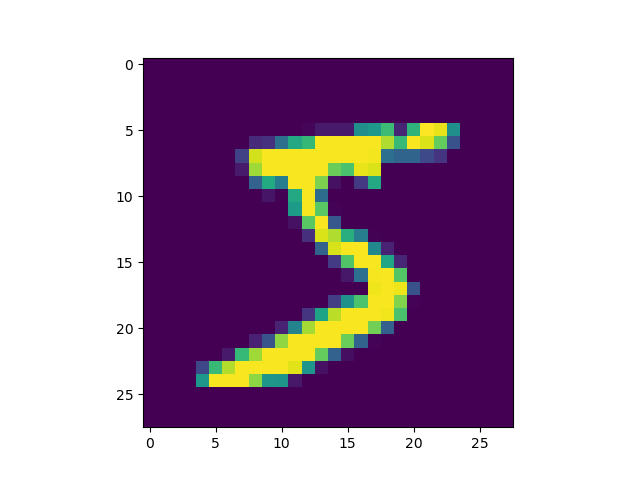

tensor(5)


In [3]:
# Load datasets in memory
train_X = torch.tensor([])
train_y = torch.tensor([])
test_X = torch.tensor([])
test_y = torch.tensor([])


for file in file_names:
    with gzip.open(file, 'r') as f:
        if 'images' in file:
            f.read(16)
            buf = f.read()
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32).reshape(-1, 28, 28)
            plt.imshow(data[0])
            
            if 'train' in file:
                train_X = torch.tensor(data)
            else:
                test_X = torch.tensor(data)

        else:
            f.read(8)
            buf = f.read()
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)

            if 'train' in file:
                train_y = torch.tensor(data)
            else:
                test_y = torch.tensor(data)

plt.imshow(train_X[0])
print(train_y[0])

In [4]:
class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 150),
            nn.ReLU(),
            nn.Linear(150, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.hidden(x)

<IPython.core.display.Javascript object>


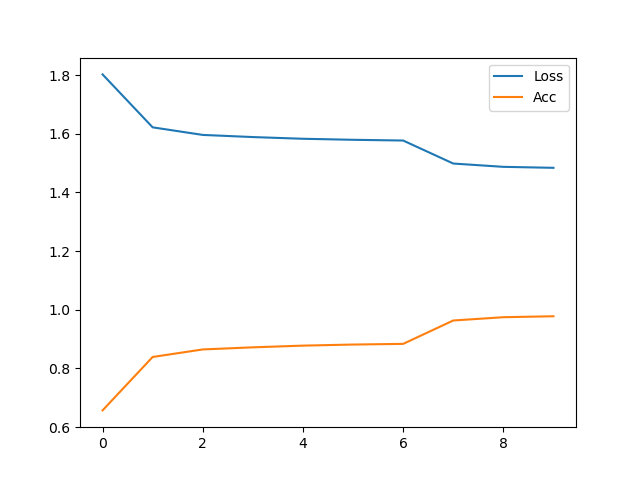

  0%|          | 0/10 [00:00<?, ?it/s]

array(1., dtype=float32)

In [5]:
model = BobNet().to(device)
BS = 64
train_dt = DataLoader(list(zip(train_X.to(device), train_y.to(device))), batch_size=BS)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
accs = []

fig, ax = plt.subplots()

epochs = 10
for epoch in (t := trange(epochs)):
    bt_losses = []
    bt_acc = []

    for (X, y) in train_dt:
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

        for p in model.parameters():
            p.grad = None
        y_hat = torch.argmax(out, dim=1)
        acc = (len(y) - torch.count_nonzero(y_hat - y)) / len(y)
        bt_acc.append(acc.cpu().numpy())
        bt_losses.append(loss.item())

    losses.append(np.array(bt_losses).mean())
    accs.append(np.array(bt_acc).mean())

ax.plot(losses, label='Loss')
ax.plot(accs, label='Acc')
ax.legend()
acc.cpu().numpy()

In [6]:
test_dt = DataLoader(list(zip(train_X.to(device), train_y.to(device))), batch_size=1)
test_accs = []

for (X, y) in train_dt:
    out = model(X)
    y_hat = torch.argmax(out, dim=1)
    acc = (len(y) - torch.count_nonzero(y_hat - y)) / len(y)
    test_accs.append(acc.cpu().numpy())
    
np.array(test_accs).mean()

0.98135996